In [1]:
!pip install torch torchvision

In [2]:
!pip install Pillow==4.1.1

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [0]:
batch_size = 128
num_epochs = 100
seed = 1
out_dir = './logs'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [0]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=True,
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=False,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

In [8]:
print(len(train_loader))
print(len(test_loader))

469
79


In [0]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(784, 512)
        self.fc21 = nn.Linear(512, 2)  # mu
        self.fc22 = nn.Linear(512, 2)  # logvar

        self.fc3 = nn.Linear(2, 512)
        self.fc4 = nn.Linear(512, 784)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h))
    
    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
data, _ = iter(train_loader).next()
outputs, mu, logvar = model(data.to(device))
print(outputs.size())
print(mu.size())
print(logvar.size())

torch.Size([128, 784])
torch.Size([128, 2])
torch.Size([128, 2])


In [0]:
def loss_function(recon_x, x, mu, logvar):
    # size_average=Falseなのでバッチ内のサンプルの合計lossを求める
    # reconstruction loss 入力画像をどのくらい正確に復元できたか？
    # 数式では対数尤度の最大化だが交差エントロピーlossの最小化と等価
    recon = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)

    # 潜在空間zに対する正則化項
    # P(z|x) が N(0, I)に近くなる（KL-distanceが小さくなる）ようにする
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon + kld

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    # loss_function() は平均ではなく全サンプルの合計lossを返すのでサンプル数で割る
    train_loss /= len(train_loader.dataset)

    return train_loss    
    

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()

            if epoch % 10 == 0:
                # 10エポックごとに最初のminibatchの入力画像と復元画像を保存
                if batch_idx == 0:
                    n = 8
                    comparison = torch.cat([data[:n],
                                            recon_batch.view(batch_size, 1, 28, 28)[:n]])
                    save_image(comparison.cpu(),
                               '{}/reconstruction_{}.png'.format(out_dir, epoch), nrow=n)

    test_loss /= len(test_loader.dataset)

    return test_loss

In [14]:
loss_list = []
test_loss_list = []
for epoch in range(0, num_epochs):
    loss = train(epoch)
    test_loss = test(epoch)

    print('epoch [{}/{}], loss: {:.4f} test_loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss,
        test_loss))

    # logging
    loss_list.append(loss)
    test_loss_list.append(test_loss)

epoch [1/100], loss: 186.8830 test_loss: 167.2359
epoch [2/100], loss: 166.0551 test_loss: 163.0600
epoch [3/100], loss: 162.8881 test_loss: 160.9862
epoch [4/100], loss: 160.5431 test_loss: 159.0624
epoch [5/100], loss: 158.8899 test_loss: 157.4793
epoch [6/100], loss: 157.5374 test_loss: 156.6287
epoch [7/100], loss: 156.5172 test_loss: 155.8802
epoch [8/100], loss: 155.6448 test_loss: 154.9735
epoch [9/100], loss: 154.7878 test_loss: 154.7507
epoch [10/100], loss: 154.0940 test_loss: 154.1243
epoch [11/100], loss: 153.5370 test_loss: 153.8041
epoch [12/100], loss: 153.0035 test_loss: 153.5052
epoch [13/100], loss: 152.4820 test_loss: 153.0326
epoch [14/100], loss: 152.0523 test_loss: 152.8520
epoch [15/100], loss: 151.6783 test_loss: 151.9912
epoch [16/100], loss: 151.2445 test_loss: 152.3436
epoch [17/100], loss: 150.8410 test_loss: 152.1450
epoch [18/100], loss: 150.5166 test_loss: 151.8635
epoch [19/100], loss: 150.2362 test_loss: 151.5215
epoch [20/100], loss: 149.9536 test_loss

epoch [63/100], loss: 144.2664 test_loss: 149.3798
epoch [64/100], loss: 144.2167 test_loss: 149.3249
epoch [65/100], loss: 144.1675 test_loss: 149.2310
epoch [66/100], loss: 144.0123 test_loss: 149.3420
epoch [67/100], loss: 143.9892 test_loss: 149.0967
epoch [68/100], loss: 143.9046 test_loss: 149.0050
epoch [69/100], loss: 143.8631 test_loss: 149.0537
epoch [70/100], loss: 143.8307 test_loss: 149.2221
epoch [71/100], loss: 143.7482 test_loss: 149.2597
epoch [72/100], loss: 143.7051 test_loss: 149.0774
epoch [73/100], loss: 143.6396 test_loss: 149.2592
epoch [74/100], loss: 143.5939 test_loss: 148.9825
epoch [75/100], loss: 143.5178 test_loss: 149.1929
epoch [76/100], loss: 143.4509 test_loss: 149.3116
epoch [77/100], loss: 143.3678 test_loss: 149.3209
epoch [78/100], loss: 143.3556 test_loss: 149.2121
epoch [79/100], loss: 143.3151 test_loss: 148.8117
epoch [80/100], loss: 143.2358 test_loss: 148.9625
epoch [81/100], loss: 143.1744 test_loss: 149.0388
epoch [82/100], loss: 143.0951 

Text(0,0.5,'loss')

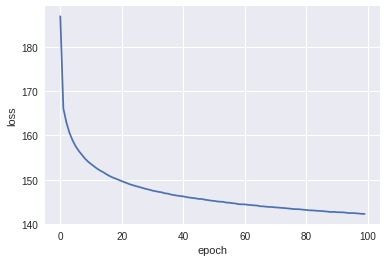

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0,0.5,'test loss')

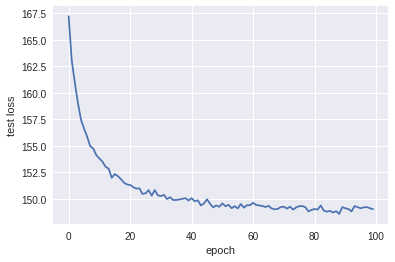

In [16]:
plt.plot(test_loss_list)
plt.xlabel('epoch')
plt.ylabel('test loss')

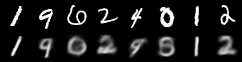

In [17]:
# 入力画像と再構成画像の比較
from IPython.display import Image
Image('logs/reconstruction_10.png')

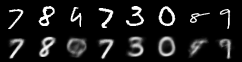

In [18]:
Image('logs/reconstruction_90.png')

In [0]:
test_dataset = datasets.MNIST('./data', download=True, train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)
images, labels = iter(test_loader).next()
images = images.view(10000, -1)

In [20]:
# 784次元ベクトルを2次元ベクトルにencode
with torch.no_grad():
    z = model.encode(images.to(device))
mu, logvar = z
mu, logvar = mu.cpu(), logvar.cpu()
print(mu.size(), logvar.size())

torch.Size([10000, 2]) torch.Size([10000, 2])


In [21]:
mu[:10]

tensor([[-0.9348,  2.4448],
        [-0.1595, -0.8729],
        [ 0.5570, -2.8679],
        [ 0.1761,  0.1297],
        [-1.1900,  0.3133],
        [ 0.3889, -2.4014],
        [-0.5778,  0.6080],
        [-2.3842,  0.6025],
        [-0.2224,  0.6439],
        [-0.2020,  1.0387]])

In [22]:
logvar[:10]

tensor([[-5.6522, -5.3017],
        [-6.4876, -6.5799],
        [-5.0874, -4.1681],
        [-7.1145, -7.2779],
        [-5.8637, -6.9146],
        [-5.3150, -4.4133],
        [-6.2792, -6.6030],
        [-4.6387, -5.6264],
        [-6.5419, -7.3428],
        [-6.5561, -5.8367]])

In [23]:
std = np.exp(0.5 * logvar)
std[:10]

tensor([[ 0.0592,  0.0706],
        [ 0.0390,  0.0373],
        [ 0.0786,  0.1244],
        [ 0.0285,  0.0263],
        [ 0.0533,  0.0315],
        [ 0.0701,  0.1101],
        [ 0.0433,  0.0368],
        [ 0.0983,  0.0600],
        [ 0.0380,  0.0254],
        [ 0.0377,  0.0540]])

(-6, 6)

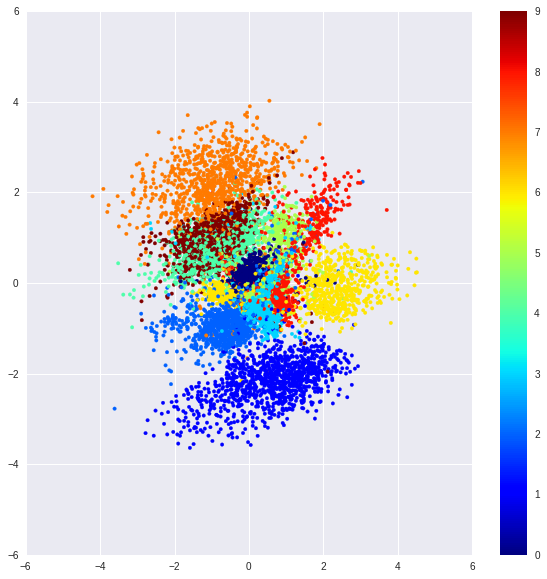

In [24]:
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.xlim((-6, 6))
plt.ylim((-6, 6))